In [8]:
import cv2, pywt
import numpy as np
import focus_stacking.utils.images as im_utils
import focus_stacking.energy.energy as energy
import focus_stacking.fusion.fusion as fusion 
import focus_stacking.pipelines.utils as pipeline_utils
import focus_stacking.utils.data_loader as data_loader
import argparse

In [2]:
# https://stackoverflow.com/questions/60593425/how-to-view-the-pyramid-of-images-generated-with-opencv
def gen_pyramid_im(levels, out_path=None, process_im=lambda x: x, gray=False):
    h,w,c = levels[0].shape
    pyr_im = np.zeros((h, w+w//2, c), dtype=np.float32)
    '''
    level_im = process_im(levels[0])
    if gray:
        level_im = im_utils.bgr_to_grayscale(level_im.astype(np.float32))
        level_im = im_utils.grayscale_to_bgr(level_im)
        print('0 ', level_im)
    pyr_im[0:h, 0:w, :c] = level_im
    '''

    y_offset = 0
    x_offset = 0
    for i in range(0, len(levels)):
        if i == 1:
            x_offset = w
            y_offset = 0
        h_, w_, c_ = levels[i].shape
        level_im = process_im(levels[i])
        if gray:
            level_im = im_utils.bgr_to_grayscale(level_im.astype(np.float32))
            level_im = im_utils.grayscale_to_bgr(level_im)
            # print(f'{i} ', level_im)
        pyr_im[y_offset:y_offset+h_, x_offset:x_offset+w_, :c_] = level_im
        y_offset = y_offset + h_

    if out_path:
        cv2.imwrite(out_path, pyr_im)

# A stack of pyramids (where each index in the stack represents
# an image/slice from the focus stack)
class StackPyramid(object):
    def __init__(self, images, depth, kernel, pyramid_type='gaussian', wvt_name=None):
        print(pyramid_type)
        if pyramid_type == 'gaussian':
            self.pyramids = [Pyramid(im, depth, kernel) for im in images]
        elif pyramid_type == 'laplacian_pyramid':
            self.pyramids = []
            for im_id, im in enumerate(images):
                lap_pyr = LaplacianPyramid(im=im, depth=depth, kernel=kernel)
                lap_pyr.display_pyramid(f'/n/fs/3d-indoor/tmp_outdir/aux/pyr_gauss_{im_id}.jpg',
                                        f'/n/fs/3d-indoor/tmp_outdir/aux/pyr_lap_{im_id}.jpg')
                self.pyramids.append(lap_pyr)
        elif pyramid_type == 'wavelet':
            self.pyramids = []
            for im_id, im in enumerate(images):
                wvt_pyr = WaveletPyramid(im=im, depth=depth, wvt_name=wvt_name)
                self.pyramids.append(wvt_pyr)
        self.max_im_h = self.pyramids[0].max_im_h
        self.max_im_w = self.pyramids[0].max_im_h
        self.min_im_h = self.pyramids[0].min_im_h
        self.min_im_w = self.pyramids[0].min_im_h
        self.depth = depth

class Pyramid(object):

    def __init__(self, im, depth, kernel=None, downsample=lambda im : im[::2, ::2, :]):
        self.depth = depth

        self.src_im = im
        self.max_im_h = self.src_im.shape[0]
        self.max_im_w = self.src_im.shape[1]
        self.min_im_h = self.max_im_h / (2**self.depth)
        self.min_im_w = self.max_im_w / (2**self.depth)

        self.kernel = kernel
        self.downsample = downsample
        self.levels = [{'image': self.src_im,
                        }]

        self.make_pyramid()

    def make_pyramid(self):
        for level_id in range(1, self.depth):
            prev_level = self.levels[level_id-1]['image']
            level = prev_level
            level = cv2.sepFilter2D(prev_level, -1, self.kernel, self.kernel)
            level = self.downsample(level)
            self.levels.append({'image': level})
            # TODO: optionally write out pyramid to image

    def display_pyramid(self, out_path):
        gen_pyramid_im(self.levels, out_path)

    def compute_energy_for_levels(self, level_id, im_key, energy_fn, energy_key=None, ksize=5, kernel=None, im_color=True):
        if energy_key is None:
            energy_key = energy_type
        self.levels[level_id][energy_key] = energy_fn(self.levels[level_id][im_key], True)




class LaplacianPyramid(Pyramid):
    def __init__(self, im=None, depth=None, levels=None, kernel=None, downsample=lambda im: im[::2, ::2, :], upsample=energy.expand_from_kernel):
        self.upsample = upsample
        if levels is None:
            super().__init__(im, depth, kernel)
        else:
            self.depth = len(levels)
            self.levels = levels
            self.kernel = kernel
            # self.max_im_h = levels[0].shape[0]
            # self.max_im_w = levels[0].shape[1]
            # self.min_im_h = levels[-1].shape[0]
            # self.min_im_w = levels[-1].shape[1]

    def make_pyramid(self):
        print('making pyramid')
        super().make_pyramid()

        for level_id in range(self.depth - 1):
            upsampled = self.upsample(self.levels[level_id + 1]['image'], self.kernel)
            #self.levels.append(upsampled)
            diff = self.levels[level_id]['image'] - upsampled
            self.levels[level_id]['laplacian'] = diff
        self.levels[-1]['laplacian'] = self.levels[-1]['image']

    def display_pyramid(self, low_pass_out_path, out_path):
        gen_pyramid_im([self.levels[level_id]['image'] for level_id in range(self.depth)], low_pass_out_path)
        gen_pyramid_im([self.levels[level_id]['laplacian'] for level_id in range(self.depth)], out_path, 
                       process_im=im_utils.normalize_with_neg, gray=True)

    # Reconstruct an image based on self.levels
    def reconstruct(self):
        image = self.levels[-1]['laplacian']
        for level in self.levels[-2::-1]:
            image = self.upsample(image, self.kernel) + level['laplacian']
        return image


class WaveletPyramid(Pyramid):
    def __init__(self, im=None, depth=5, levels=None, wvt_name='db6'):
        self.wvt_name = wvt_name
        self.downsample = lambda im : pywt.dwt2(im, self.wvt_name)
        self.upsample = lambda coeff : pywt.idwt2(coeff, self.wvt_name)
        self.upsample_full = lambda coeff : pywt.waverec2(coeff, self.wvt_name)
        if levels is None:
            super().__init__(im, depth, kernel=None, downsample=self.downsample)
        else:
            self.depth = len(depth)
            self.levels = levels
            self.kernel = None
            
    def make_pyramid(self):
        print('making pyramid')
        LL = self.levels[0]['image']
        for level_id in range(self.depth):
            coeffs2 = self.downsample(self.levels[level_id]['image'])
            LL, (LH, HL, HH) = coeffs2
            self.levels[level_id]['LH'] = LH
            self.levels[level_id]['HL'] = HL
            self.levels[level_id]['HH'] = HH
            self.levels.append({'image': LL})
            
    def reconstruct(self):
        coeffs = [self.levels[-1]['image']]+[(l['LH'], l['HL'], l['HH']) for l in self.levels[-2::-1]]
        for l in self.levels[-2::-1]:
            print(l['LH'].shape, l['HL'].shape, l['HH'].shape)
        image = self.upsample_full(coeffs)
        return image

In [3]:
aux_out_dir = '/n/fs/3d-indoor/tmp_outdir/aux/'
registered_images = data_loader.load_images_from_dir(aux_out_dir, match='reg_*.jpg')

In [12]:

ENERGIES = ['local_variance', 'local_entropy', 'local_region', 'laplacian', 'self', 'squared']
FUSION_STRATEGIES = ['max', 'multi_max']
SCALE_TRANSFORMS = ['laplacian_pyramid', 'wavelet']
PIPELINES = ['simple', 'scale_transform']

parser = argparse.ArgumentParser(formatter_class=argparse.RawTextHelpFormatter)
parser.add_argument('--data.obj', type=str, help='top level object directory', dest='obj')
parser.add_argument('--data.view', type=str, help='view dir, formatted as 03:d', dest='view')
parser.add_argument('--data.fnum', choices=['f4.0', 'f5.6', 'f6.3', 'f13', 'f22'], type=str, help='aperture size', dest='fnum')
parser.add_argument('--data.src_dir', type=str, help='manually specify full path to image source directory', dest='src_dir')

parser.add_argument('--register.load', action='store_true', help='if true, load registered images from aux dir and skip alignment', dest='load_reg_images')
parser.add_argument('--register.save_images', action='store_true', help='write registered images to aux output directory', dest='reg_save_im')
parser.add_argument('--register.ref_im_idx', type=int, help='reference image to align image to', dest='ref_im_idx', default=0)
parser.add_argument('--register.res', type=int, help='downscale image by [res] for warping only', dest='warp_res', default=1)
parser.add_argument('--register.max_iters', type=int, help='max iterations for ECC', dest='align_max_iters', default=50)
parser.add_argument('--register.eps', type=float, help='termination eps for ECC', dest='align_eps', default=1e-3)

parser.add_argument('--pipeline', type=str, choices=PIPELINES)

parser.add_argument('--simple.energies', nargs='+', choices=ENERGIES, dest='simple_energies')
parser.add_argument('--simple.fusion', choices=FUSION_STRATEGIES, dest='simple_fusion')

parser.add_argument('--scale_transform.type', type=str, choices=SCALE_TRANSFORMS, help='energies used for pyramid base fusion', dest='st_type')
parser.add_argument('--scale_transform.kwidth', type=int, help='kernel width for pyramid construction', default=63, dest='st_kwidth')
parser.add_argument('--scale_transform.depth', type=int, help='pyramid depth/number of levels in pyramid', default=5, dest='st_depth')
parser.add_argument('--scale_transform.base_energies', nargs='+', choices=ENERGIES, help='energies used for pyramid base fusion', dest='st_base_energies')
parser.add_argument('--scale_transform.base_fusion', choices=FUSION_STRATEGIES, help='energies used for pyramid base fusion', dest='st_base_fusion')
parser.add_argument('--scale_transform.level_energies', nargs='+', choices=ENERGIES, help='energies used for pyramid base fusion', dest='st_level_energies')
parser.add_argument('--scale_transform.level_fusion',  choices=FUSION_STRATEGIES, help='energies used for pyramid base fusion', dest='st_level_fusion')

parser.add_argument('--energy.variance.neighborhood', type=int, dest='energy_variance_neighborhood')
parser.add_argument('--energy.entropy.neighborhood', type=int, dest='energy_entropy_neighborhood')
parser.add_argument('--energy.region.neighborhood', type=int, dest='energy_region_neighborhood')
parser.add_argument('--energy.region.kwidth', type=int, dest='energy_region_kwidth')
parser.add_argument('--energy.laplacian.neighborhood', type=int)
parser.add_argument('--energy.laplacian.kwidth', type=int)

parser.add_argument('--out_dir', type=str, help='manually specify output directory')
parser.add_argument('--out_fname', type=str, default='fused_im.jpg')
parser.add_argument('--aux_out_dir', type=str, help='manually specify auxiliary output directory')
parser.add_argument('--results_out_dir', type=str, help='manually specify results output directory')

#subparsers = parser.add_subparsers(dest='method')
    
cmd_line = ['--data.obj', 'snail',
            '--data.view', '000',
            '--data.fnum', 'f4.0',
            '--pipeline', 'scale_transform',
            '--scale_transform.type', 'laplacian_pyramid',
            '--scale_transform.kwidth', '63',
            '--scale_transform.depth', '5',
            '--scale_transform.base_energies', 'local_variance', 'local_entropy',
            '--scale_transform.base_fusion', 'multi_max',
            '--scale_transform.level_energies', 'local_region',
            '--scale_transform.level_fusion', 'max',
            '--energy.variance.neighborhood', '9',
            '--energy.entropy.neighborhood', '9',
            '--energy.region.neighborhood', '9',
            '--energy.region.kwidth', '63', 
            ]
args = parser.parse_args(cmd_line)

In [13]:
args

Namespace(align_eps=0.001, align_max_iters=50, aux_out_dir=None, energy_entropy_neighborhood=9, energy_region_kwidth=63, energy_region_neighborhood=9, energy_variance_neighborhood=9, fnum='f4.0', load_reg_images=False, obj='snail', out_dir=None, out_fname='fused_im.jpg', pipeline='scale_transform', ref_im_idx=0, reg_save_im=False, results_out_dir=None, simple_energies=None, simple_fusion=None, src_dir=None, st_base_energies=['local_variance', 'local_entropy'], st_base_fusion='multi_max', st_depth=5, st_kwidth=63, st_level_energies=['local_region'], st_level_fusion='max', st_type='laplacian_pyramid', view='000', warp_res=1, **{'energy.laplacian.kwidth': None, 'energy.laplacian.neighborhood': None})

In [14]:
low_pass_kernel = cv2.getGaussianKernel(args.st_kwidth, sigma=-1)
down_pyramid = StackPyramid(registered_images, depth=args.st_depth, kernel=low_pass_kernel, pyramid_type=args.st_type)
level_energy_fns = {}
for energy_name in args.st_level_energies:
    fn = pipeline_utils.get_energy_fn(energy_name, args)
    for pyramid in down_pyramid.pyramids:
        for level in range(pyramid.depth):
            pyramid.compute_energy_for_levels(level, im_key='laplacian', energy_fn = fn, energy_key=energy_name)

for energy_name in args.st_base_energies:
    fn = pipeline_utils.get_energy_fn(energy_name, args)
    for pyramid in down_pyramid.pyramids:
        pyramid.compute_energy_for_levels(-1, im_key='laplacian', energy_fn = fn, energy_key=energy_name)


base_ims = [pyramid.levels[-1]['laplacian'] for pyramid in down_pyramid.pyramids]
base_entropy = [pyramid.levels[-1]['local_entropy'] for pyramid in down_pyramid.pyramids]
base_variance = [pyramid.levels[-1]['local_variance'] for pyramid in down_pyramid.pyramids]
fused_base = fusion.fuse_multiple_max([base_entropy, base_variance], base_ims)

fused_layers = [{'laplacian': fusion.fuse_max([pyramid.levels[level]['local_region'] for pyramid in down_pyramid.pyramids],
                                [pyramid.levels[level]['laplacian'] for pyramid in down_pyramid.pyramids])
                for level in range(down_pyramid.depth - 1)}]
fused_layers.append({'laplacian':fused_base})

reconstruction_pyramid = LaplacianPyramid(levels=fused_layers, kernel=low_pass_kernel)
fused_im = reconstruction_pyramid.reconstruct()

laplacian_pyramid
making pyramid


[ WARN:0@404.597] global loadsave.cpp:848 imwrite_ Unsupported depth image for selected encoder is fallbacked to CV_8U.


making pyramid
making pyramid
making pyramid
making pyramid
making pyramid
making pyramid
making pyramid
making pyramid


/n/fs/3d-indoor/focus_stacking/focus_stacking/pipelines/utils.py:13: UserWarning: Possible precision loss converting image of type float32 to uint8 as required by rank filters. Convert manually using skimage.util.img_as_ubyte to silence this warning.
  return lambda im, im_color : energies.local_entropy(im,


SyntaxError: 'return' outside function (1941050924.py, line 28)

In [15]:
import matplotlib.pyplot as plt

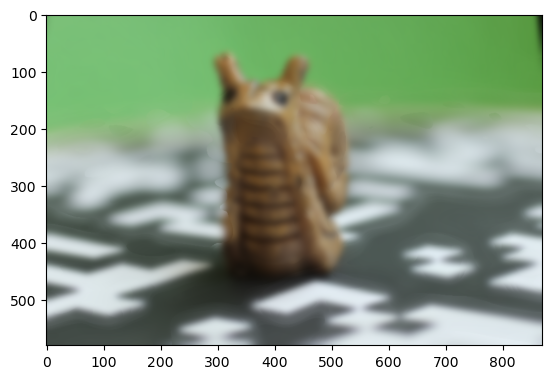

In [18]:
plt.imshow(im_utils.bgr_to_rgb(fused_im/255))

In [26]:
down_pyramid.pyramids[0].levels[0]['laplacian'].shape

(4640, 6960, 3)

In [28]:
fused_layers[0]['laplacian'].shape

(580, 870, 3)

In [31]:
down_pyramid.depth

5

In [34]:
fused_layers = [{'laplacian': fusion.fuse_max([pyramid.levels[level]['local_region'] for pyramid in down_pyramid.pyramids],
                                [pyramid.levels[level]['laplacian'] for pyramid in down_pyramid.pyramids])
                } for level in range(down_pyramid.depth - 1)]

In [35]:
len(fused_layers)

4

In [36]:
fused_layers.append({'laplacian':fused_base})

reconstruction_pyramid = LaplacianPyramid(levels=fused_layers, kernel=low_pass_kernel)
fused_im = reconstruction_pyramid.reconstruct()

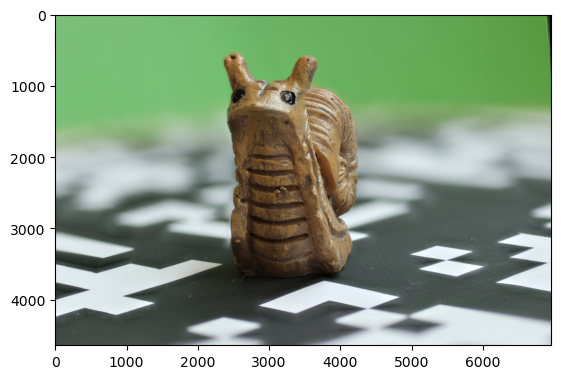

In [37]:
plt.imshow(im_utils.bgr_to_rgb(fused_im/255))